# Analysis of Nea. ancestry

In [1]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)

source("../code/utils.R")

})

In [2]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [3]:
samples %<>% filter(!pop %in% c("Africa", "Oceania"))

# Calculating Nea ancestry using different ratios of f4 statistics

We used the data set containing the new Vindija sample:

In [4]:
EIGENSTRAT_DIR <- "../data/eigenstrat/bigyri_ho/"

EIGENSTRAT_OLD <- paste0(EIGENSTRAT_DIR, "all")
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "all_BigYRI")

SNP_FILE <- paste0(EIGENSTRAT, ".snp")
GENO_FILE <- paste0(EIGENSTRAT, ".geno")
IND_FILE <- paste0(EIGENSTRAT, ".ind")

subset_sites(prefix=EIGENSTRAT_OLD, out_prefix=EIGENSTRAT, bed_file="../data/bed/bigyri_array.bed")

### Calculate the number of SNPs available for each sample on the 2.2M array

In [5]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

<br><br><br><br><br><br><br><br>
# Calculations of Nea ancestry estimate

## Nea. ancestry proportions using David's f4 ratio

In [6]:
merge_pops(IND_FILE, paste0(IND_FILE, ".IceAge"),
           merge=list(West_and_Central_Africans=c("Yoruba", "Mbuti", "Mende"),
                      Archaics=c("new_Altai", "new_Denisova")))

In [7]:
iceage_Nea <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                        prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".IceAge"))

# Our new f4 ratio estimate

More straightforward & should be measuring what we _really_ want to measure

In [8]:
yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT)
mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)
mende  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mende", O="Chimp", prefix=EIGENSTRAT)
dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

In [9]:
merge_pops(IND_FILE, paste0(IND_FILE, ".Africans"),
           merge=list(Africans=c("Yoruba", "Mbuti", "Mende", "Dinka")))

In [10]:
africans  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Africans", O="Chimp", prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".Africans"))

In [11]:
options(repr.plot.width=9, repr.plot.height=5)

### Merge all f4 results:

In [12]:
results <- inner_join(bind_rows(iceage_Nea, mbuti,  yoruba, mende, dinka, africans),
                      snp_counts_f4, by=c("X"="name")) %>%
    select(-c(A, B, C, O)) %>%
    inner_join(samples, by=c("X"="name")) %>%
    mutate(stderr=alpha / Zscore) %>%
    mutate(sites="BigYRI")

# Plot Nea. estimates over time

In [13]:
non_udg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

In [14]:
eur_nea <- filter(results, pop %in% c("EMH", "WestEurasia"),
                  !X %in% non_udg_samples,
                  !X %in% c("BedouinB", "Druze", "Iranian", "Iraqi_Jew",
                               "Jordanian", "Palestinian", "Samaritan", "Turkish", "Yemenite_Jew"))

In [28]:
plot_nea_vs_time <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=-Inf, ylim=c(0, 0.1), plot_ci=TRUE) {
    x <- if (plot_ci) 1.96 else 0
    filter(eur_nea,
           setup == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>% {(
    ggplot(., aes(age, alpha)) +
        geom_point(aes(size=snp_count, color=abs(Zscore) > 3), alpha=3/4) +
        geom_errorbar(aes(ymin=alpha - x * stderr, ymax=alpha + x * stderr, color=abs(Zscore) > 3)) +
        geom_smooth(aes(weight=snp_count), data=filter(., abs(Zscore) > x), method="lm", linetype=2, fullrange=TRUE, size=0.5) +
        xlab("age [years before present]") + ylab("Neanderthal ancestry proportion") +
        xlim(47000, 0) + ylim(ylim[1], ylim[2]) #+
        #ggtitle(paste0("analysis setup: ", m))
    )}
}

run_lm <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=0) {
    filter(eur_nea,
           setup == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>%
    { lm(.[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]]) }
}

## Results from the Ice Age paper

In [29]:
cutoff <- 50000

In [30]:
options(repr.plot.width=9, repr.plot.height=5)

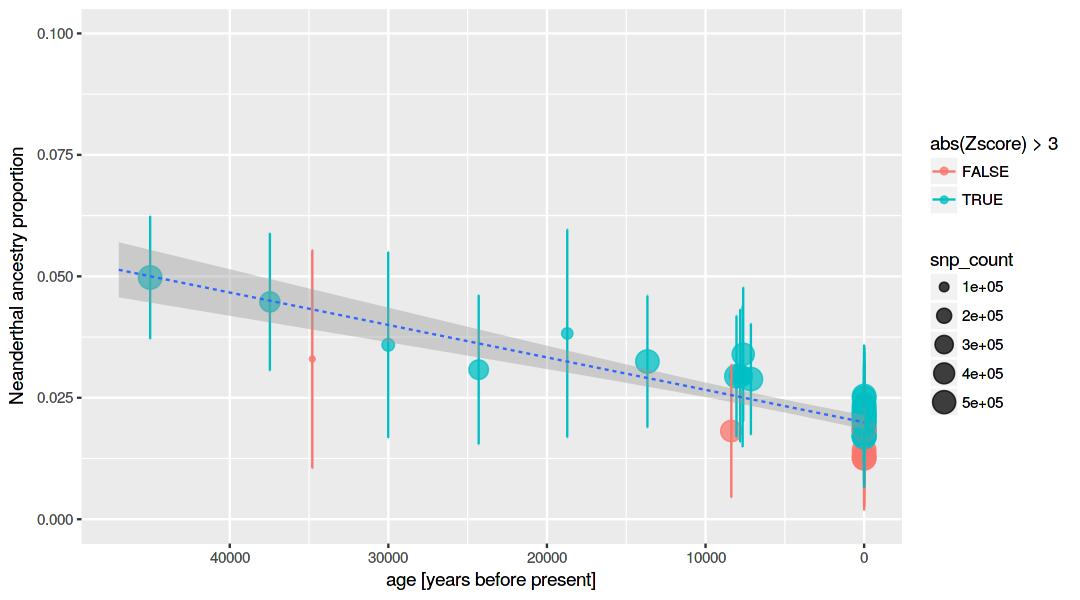

In [31]:
plot_nea_vs_time("qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp", ylim=c(0, 0.1), snp_cutoff=cutoff)

# New f4 results

In [32]:
options(repr.plot.width=9, repr.plot.height=5)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-9232840 -3835218  -582833  3164658 21426399 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)    -39974      12800  -3.123  0.00347 **
.[["alpha"]]  1747720     499044   3.502  0.00122 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6242000 on 37 degrees of freedom
Multiple R-squared:  0.249,	Adjusted R-squared:  0.2287 
F-statistic: 12.26 on 1 and 37 DF,  p-value: 0.001224



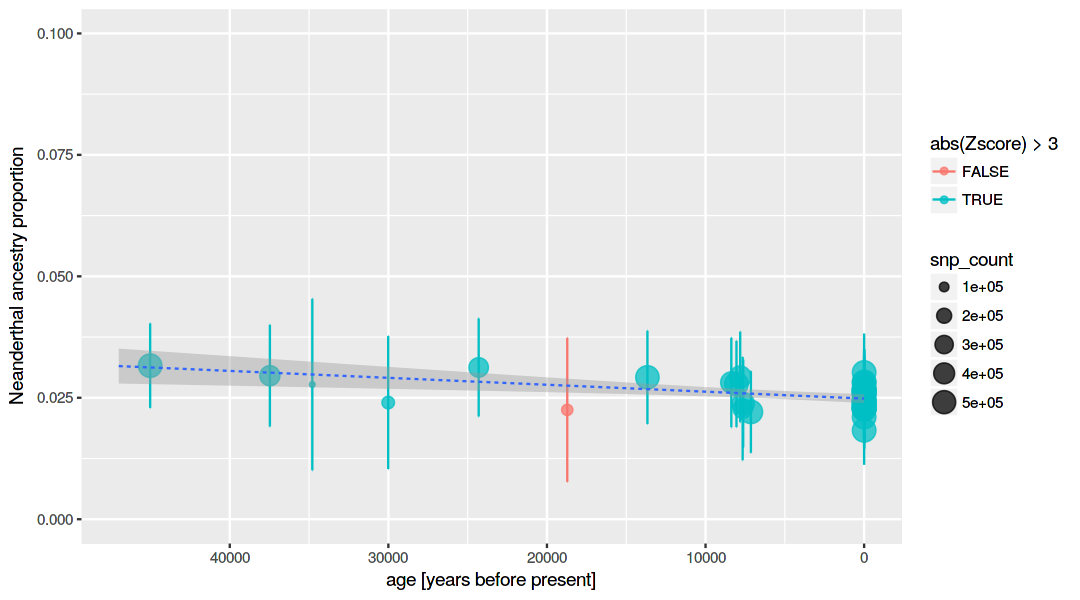

In [33]:
"qpF4ratio__new_Altai_new_Vindija_Africans_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-9347414 -3773956  -475395  2769719 21290483 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -38220      11631  -3.286 0.002230 ** 
.[["alpha"]]  1786725     482021   3.707 0.000684 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6150000 on 37 degrees of freedom
Multiple R-squared:  0.2708,	Adjusted R-squared:  0.2511 
F-statistic: 13.74 on 1 and 37 DF,  p-value: 0.0006842



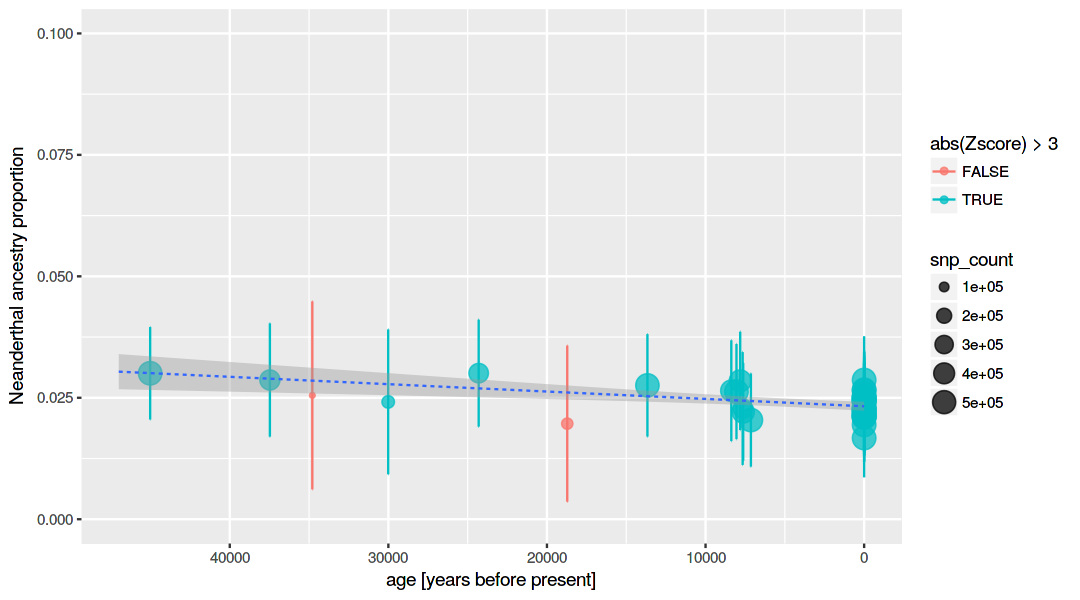

In [34]:
"qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-9353190 -3794796  -597328  3198861 21303097 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -37804      11365  -3.326 0.001996 ** 
.[["alpha"]]  1792870     477112   3.758 0.000591 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6127000 on 37 degrees of freedom
Multiple R-squared:  0.2762,	Adjusted R-squared:  0.2567 
F-statistic: 14.12 on 1 and 37 DF,  p-value: 0.0005907



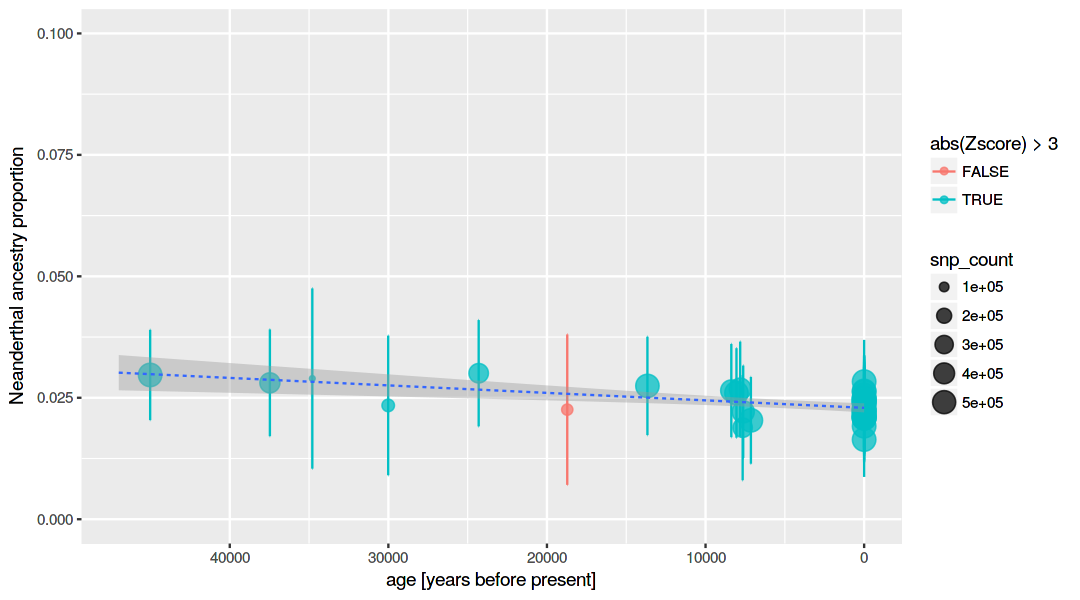

In [35]:
"qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-8956265 -3854794  -910963  2707692 21653634 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)    -49732      16855  -2.950  0.00548 **
.[["alpha"]]  1683645     520646   3.234  0.00257 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6359000 on 37 degrees of freedom
Multiple R-squared:  0.2204,	Adjusted R-squared:  0.1993 
F-statistic: 10.46 on 1 and 37 DF,  p-value: 0.002572



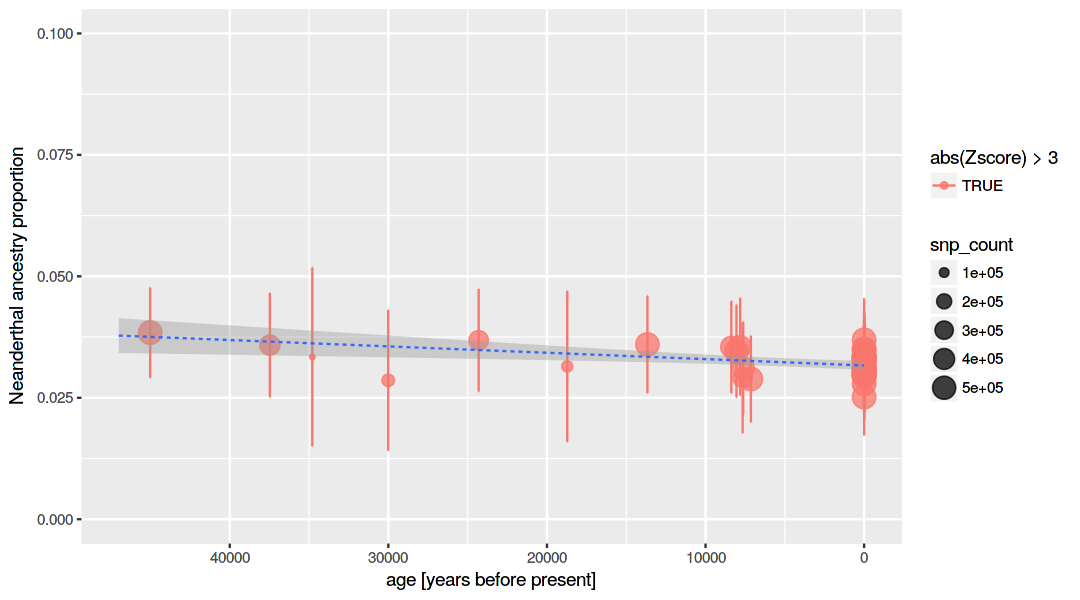

In [36]:
"qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-8534335 -3831011  -993487  2885823 22359985 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)    -27374      10936  -2.503   0.0169 * 
.[["alpha"]]  1510433     512245   2.949   0.0055 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6481000 on 37 degrees of freedom
Multiple R-squared:  0.1903,	Adjusted R-squared:  0.1684 
F-statistic: 8.695 on 1 and 37 DF,  p-value: 0.005503



Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

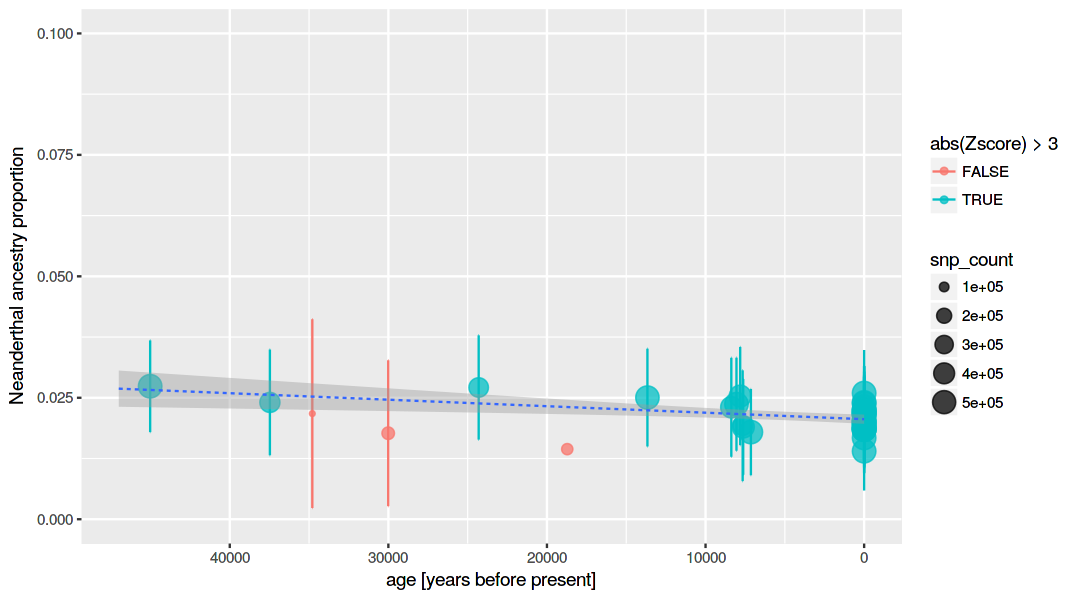

In [37]:
"qpF4ratio__new_Altai_new_Vindija_Mende_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}

## Europeans vs East Asians

In [38]:
options(repr.plot.width=9, repr.plot.height=4)

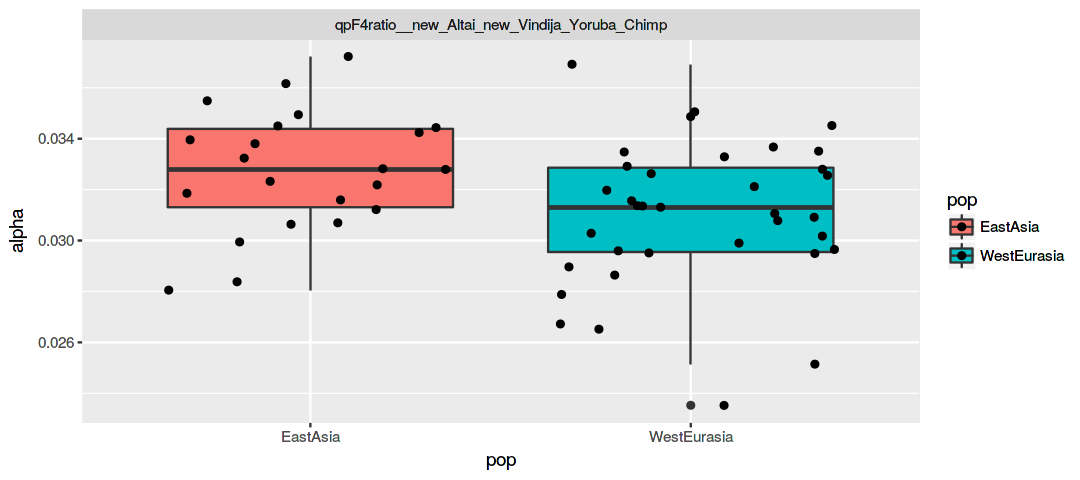

In [39]:
filter(results,
       pop %in% c("WestEurasia", "EastAsia"),
       setup %in% c("direct", "qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp")) %>%
ggplot(aes(pop, alpha, fill=pop)) + geom_boxplot() + geom_jitter() + facet_grid(~ setup)

In [42]:
inner_join(bind_rows(mbuti,  yoruba, mende, dinka, africans), snp_counts_f4, by=c("X"="name")) %>%
    inner_join(samples, by=c("X"="name")) %>%
    mutate(sites="BigYRI") %>%
    saveRDS("../paper/rds/direct_f4_BigYRI.rds")

inner_join(iceage_Nea, snp_counts_f4, by=c("X"="name")) %>%
    inner_join(samples, by=c("X"="name")) %>%
    mutate(sites="BigYRI") %>%
    saveRDS("../paper/rds/indirect_f4_BigYRI.rds")